<a href="https://colab.research.google.com/github/Niharikajo/gridworld/blob/main/gw_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Creating a Gridworld game
from Gridworld import Gridworld #gridworld game is imported
game = Gridworld(size=4, mode='static') # size and mode of the game is passed on 

In [ ]:
# after taking the specified  parameters the following game is created 
game.display() # game is displayed

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.makeMove('d') # a down move is made
game.makeMove('d') #down move is made
game.makeMove('l') #left move is made
game.display() #game is displyed with updated position of P


array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.reward()  #every nonwinning move receives a –1 reward

-1

In [ ]:
game.board.render_np() #this shows how the game state is actually represented

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
# Neural network Q function
import numpy as np #import numpy library
import torch #import pytorch library
from Gridworld import Gridworld #import gridworld game
from IPython.display import clear_output #clear_output is imported
import random #import random
from matplotlib import pylab as plt #pylab is imported from matplotlib

l1 = 64 #layer 1 (length is 64 vector)
l2 = 150 #layer 2 (length 150 vector)
l3 = 100 #layer 3 (length 100 vector)
l4 = 4  #layer 4 (length 4 vector)

# set up the neural network model

model = torch.nn.Sequential(   #sequential madule applies other modules in sequence to produce its output
    torch.nn.Linear(l1, l2),   #linear module creats single layer feed forward network with l1 inputs and l2 outputs 
    torch.nn.ReLU(),           #ReLu module gives max(0,l2) as o/p which is fed as input to next layer
    torch.nn.Linear(l2, l3),   #linear module  takes input from previous function and gives l3 outputs 
    torch.nn.ReLU(),           #ReLu module gives max(0,l3) as o/p which is fed as input to next layer
    torch.nn.Linear(l3,l4)     #linear module  takes input from previous function and gives l4 outputs 
)
#define a loss function
loss_fn = torch.nn.MSELoss()
# define the learning rate
learning_rate = 1e-3 
#set up an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

In [ ]:
#action set
#Gridworld game engine’s makeMove method expects a character such as u to make a move,
#but our Q-learning algorithm only knows how to generate numbers, so we need a simple map from numeric keys to action characters
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [ ]:
# Q-learning: Main training loop
epochs = 1000
losses = [] #Creates a list to store loss values so we can plot the trend later
for i in range(epochs): # a for loop is set up for the number of epochs
    game = Gridworld(size=4, mode='static') #For each epoch, we start a new game.
    #After we create the game,we extract the state information and add a small amount of noise.
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0  
    
    state1 = torch.from_numpy(state_).float()#Converts the numpy array into a PyTorch tensor and then into a PyTorch variable
    status = 1 #Uses the status variable to keep track of whether or not the game is still in progress
    while(status == 1): #While this game is still in progress, plays to completion and then starts a new epoch
        qval = model(state1) #Runs the Q-network forward to get its predicted Q values for all the actions
        qval_ = qval.data.numpy() #pytorch variable is converted to numpy variable
        if (random.random() < epsilon): #Selects an action using the epsilon-greedy method
            action_ = np.random.randint(0,4) #random number is selected between 0 to 4
        else:
            action_ = np.argmax(qval_) #best action is selected from predicted Q values
        
        action = action_set[action_]#Translates the numerical action into one of the action characters that our Gridworld game expects
        game.makeMove(action) #based on the action selected move is made
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #After making a move, gets the new state of the game
        reward = game.reward() #reward is collected
        with torch.no_grad():
            newQ = model(state2.reshape(1,64)) #new Q values are predicted from new state
        maxQ = torch.max(newQ) #Finds the maximum Q value predicted from the new state 
        if reward == -1: #Calculates the target Q value
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #Creates a copy of the qval array and then updates the one element corresponding to the action taken
        loss = loss_fn(X, Y) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #If reward is –1, the game hasn’t been won or lost and is still in progress
            status = 0
    if epsilon > 0.1: #Decrements the epsilon value after each epoch

        epsilon -= (1/epochs)

999 0.23754951357841492


Text(0, 0.5, 'Loss')

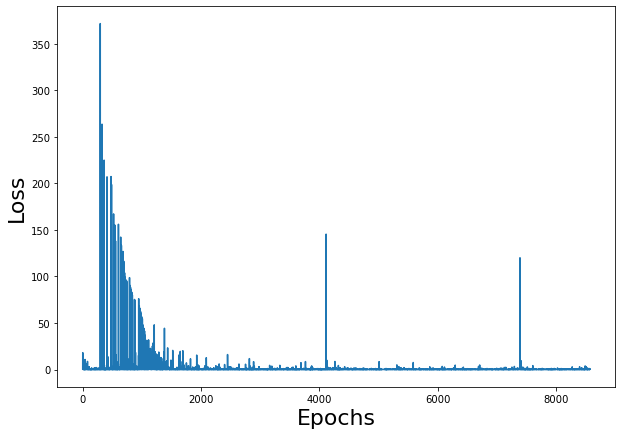

In [ ]:
#plot losses
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
# Testing the Q-network
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #extract the state information and add a small amount of noise
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display()) # inital game state before making any move
    status = 1
    while(status == 1): #While the game is still in progress
        qval = model(state)#Runs the Q-network forward to get its predicted Q values for all the actions
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #Takes the action with the highest Q value

        action = action_set[action_]#Translates the numerical action into one of the action characters that our Gridworld game expects
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action) #action is taken
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #new state is updated
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display()) # game is displayed 
        reward = test_game.reward() # reward is calculated 
        if reward != -1: #if reward= -1 then game not completed yet
            if reward > 0:  #reward greater then 0 implies P has reached +
                status = 2  #game won
                if display:
                    print("Game won! Reward: %s" % (reward,)) 
            else:
                status = 0 #game lost
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1 # i is updated after every move
        if (i > 15): 
            if display:
                print("Game lost; too many moves.") # if more then 15 moves are made and the game is still in progess then game is declared lost
            break #end game
    
    win = True if status == 2 else False
    return win 

In [ ]:
test_model(model) # test model

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [ ]:
test_model(model,'random')

Initial State:
[['W' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['W' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['W' ' ' ' ' '-']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 7; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 8; Taking action: u
[['W' ' ' ' ' '-']
 ['P' ' ' ' ' ' ']
 [

False

as we saw above the training loop works perfectly for static mode but not in random mode there is  catastrophic forgetting to prevent that we use  Experience replay

In [ ]:
# same Neural network Q function is used for the training loop using experience replay

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [ ]:
from collections import deque #deque (double ended queue) is imported
epochs = 5000
losses = []
mem_size = 1000 #Set the total size of the experience replay memory
batch_size = 200 #Set the minibatch size
replay = deque(maxlen=mem_size) #Create the memory replay as a deque list
max_moves = 50 # Maximum number of moves before game is over
h = 0
for i in range(epochs):  # a for loop is set up for the number of epochs For each epoch, we start a new game.
    game = Gridworld(size=4, mode='random') #game specifics are set
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0 #we extract the state information and add a small amount of noise.
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #Compute Q-values from input state in order to select action
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #Select action using epsilon-greedy strategy
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] #Translates the numerical action into one of the action characters that our Gridworld game expects
        if display:
            game.makeMove(action) # action is executed
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float() # gets the new state of the game
        reward = game.reward() #reward is collected
        done = True if reward > 0 else False #game is completed if the reward is greater then 0
        exp =  (state1, action_, reward, state2, done) #Create experience of state, reward, action and next state as a tuple
        replay.append(exp) # Add experience to experience replay list
        state1 = state2 #new state is assigned to state 1
        
        if len(replay) > batch_size: #If replay list is at least as long as minibatch size, begin minibatch training
            minibatch = random.sample(replay, batch_size) #Randomly sample a subset of the replay list
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #Separate out the components of each experience into separate minibatch tensors
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #Re-compute Q-values for minibatch of states to get gradients
            with torch.no_grad():
                Q2 = model(state2_batch) #Compute Q-values for minibatch of next states but don't compute gradients
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #Compute the target Q-values we want the DQN to learn
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #If game is over, reset status and mov number
            status = 0
            mov = 0
losses = np.array(losses)


4999 0.029285812750458717


Text(0, 0.5, 'Loss')

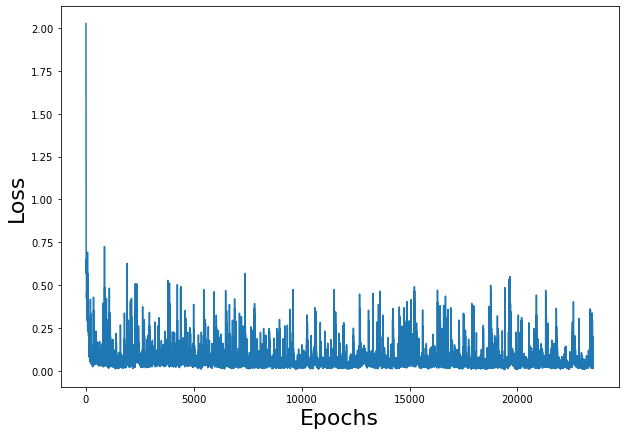

In [ ]:
#loss is ploted
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
#Testing the performance with experience replay
max_games = 1000 # 1000 games are played 
wins = 0 #initial wins
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1 # increment wins
win_perc = float(wins) / float(max_games) #percentage wins
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 943
Win percentage: 94.3%


In [ ]:
#Target network
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) #Creates a second model by making an identical copy of the original Q-network model
model2.load_state_dict(model.state_dict()) #Copies the parameters of the original model

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [ ]:
#DQN with experience replay and target network
from collections import deque #deque (double ended queue) is imported
epochs = 5000
losses = []
mem_size = 1000 #Set the total size of the experience replay memory
batch_size = 200 #Set the minibatch size
replay = deque(maxlen=mem_size) #Create the memory replay as a deque list
max_moves = 50 # Maximum number of moves before game is over
sync_freq = 500 # Set the update frequency for synchronizing the target model parameters to the main DQN
h = 0
j=0
for i in range(epochs):  # a for loop is set up for the number of epochs For each epoch, we start a new game.
    game = Gridworld(size=4, mode='random') #game specifics are set
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0 #we extract the state information and add a small amount of noise.
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1):
        j+=1
        mov += 1
        qval = model2(state1) #Compute Q-values from input state in order to select action
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #Select action using epsilon-greedy strategy
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] #Translates the numerical action into one of the action characters that our Gridworld game expects
        if display:
            game.makeMove(action) # action is executed
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float() # gets the new state of the game
        reward = game.reward() #reward is collected
        done = True if reward > 0 else False #game is completed if the reward is greater then 0
        exp =  (state1, action_, reward, state2, done) #Create experience of state, reward, action and next state as a tuple
        replay.append(exp) # Add experience to experience replay list
        state1 = state2 #new state is assigned to state 1
        
        if len(replay) > batch_size: #If replay list is at least as long as minibatch size, begin minibatch training
            minibatch = random.sample(replay, batch_size) #Randomly sample a subset of the replay list
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #Separate out the components of each experience into separate minibatch tensors
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #Re-compute Q-values for minibatch of states to get gradients
            with torch.no_grad():
                Q2 = model2(state2_batch) #Use the target network to get the maiximum Q-value for the next state
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #Compute the target Q-values we want the DQN to learn
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #Copy the main model parameters to the target network
                model2.load_state_dict(model.state_dict())

        if reward != -1 or mov > max_moves: #If game is over, reset status and mov number
            status = 0
            mov = 0
losses = np.array(losses)


999 0.09227195382118225


Text(0, 0.5, 'Loss')

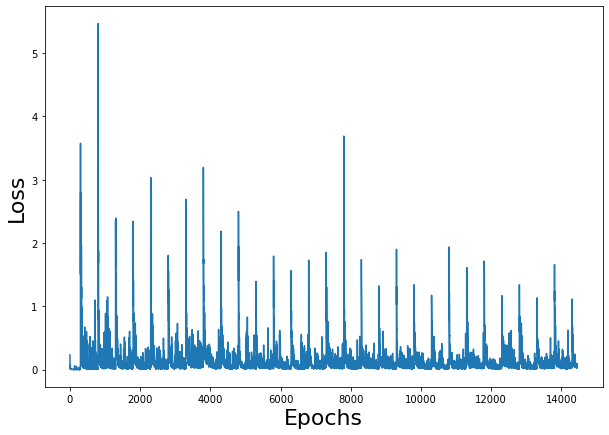

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 725
Win percentage: 72.5%
